In [1]:
using Revise

In [5]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra
;

In [575]:
H_operator = :(
    B * Rotation +
    B_z * Zeeman
)
parameters = @params begin
    B = 1.
    B_z = 0.
end

# Create basis states
QN_bounds = (N = 0,)
ground_states = enumerate_states(AngularMomentumState, QN_bounds)
QN_bounds = (N = 1,)
excited_states = enumerate_states(AngularMomentumState, QN_bounds)

basis = [ground_states; excited_states]

H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)
evaluate!(H)
QuantumStates.solve!(H)
update_basis_tdms!(H)
update_tdms!(H)
;

In [645]:
# Laser parameters
s = 2.
ω = 2π * energy(H.states[3])

const lin = [0,1,0]
const phase = π/2

k̂ = +ẑ;

ϵ_(ϵ1) = t -> ϵ1

ϵ1 = ϵ_(lin)
laser1 = Field(k̂, ϵ1, ω, s)

ϵ2 = ϵ_(exp(im * π) * lin)
laser2 = Field(k̂, ϵ2, ω, s)

lasers = [laser1]
;

In [646]:
function update_H(H, p, τ)
    H .= p.H₀
end
;

In [661]:
# OBE parameters
particle = Particle()
freq_res = 1e-1

ψ0 = zeros(ComplexF64, length(H.states))
ψ0[1] = 1.0

# π/2 pulse
(dψ, ψ, p) = schrödinger(particle, H.states, H.matrix .* 0., [laser1], H.tdms, nothing, ψ0, false, update_H)

t_end = π/2
tspan1 = (0., π/2)
times1 = range(tspan1[1], tspan1[2], 10000)
prob1 = ODEProblem(ψ!, ψ0, tspan, p)
@time sol1 = DifferentialEquations.solve(prob1, alg=DP5(), reltol=1e-3, saveat=times1)

# variable precession
(dψ, ψ, p) = schrödinger(particle, H.states, H.matrix, Field[], H.tdms, nothing, ψ0, false, update_H)

precession_time = 4.3π
tspan2 = (π/2, π/2 + precession_time)
times2 = range(tspan2[1], tspan2[2], 10000)
prob2 = ODEProblem(ψ!, sol1.u[end], tspan2, p)
@time sol2 = DifferentialEquations.solve(prob2, alg=DP5(), reltol=1e-3, saveat=times2)

# π/2 pulse
(dψ, ψ, p) = schrödinger(particle, H.states, H.matrix .* 0., [laser2], H.tdms, nothing, ψ0, false, update_H)

tspan3 = (π/2 + precession_time, π + precession_time)
times3 = range(tspan3[1], tspan3[2], 10000)
prob3 = ODEProblem(ψ!, sol2.u[end], tspan3, p)
@time sol3 = DifferentialEquations.solve(prob3, alg=DP5(), reltol=1e-4, saveat=times3)
;

  0.001799 seconds (10.06 k allocations: 1.774 MiB)
  0.002099 seconds (10.41 k allocations: 1.817 MiB)
  0.001871 seconds (10.06 k allocations: 1.774 MiB)


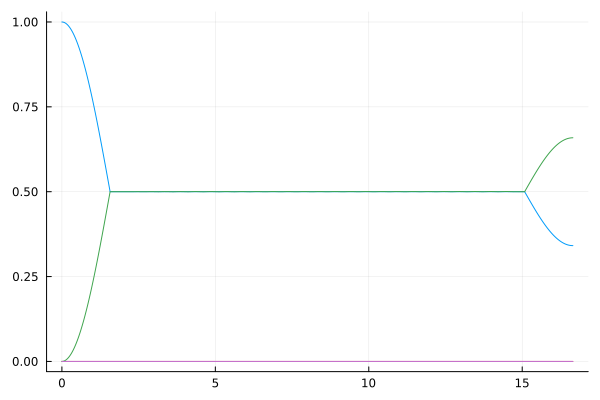

In [662]:
using Plots
us = [sol1.u; sol2.u; sol3.u]
ts = [times1; times2; times3]

plot(legend=nothing)
for i in 1:size(us[1], 1)
    plot!(ts, [real(conj(u[i]) * u[i]) for u in us])
end
plot!()